<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:**
- Perez Balcorta, Leonardo Xavier
- Castillejos Jauregui, Claudia Celeste

**Fecha:** 07 de enero del 2023.

**Expediente** :
- 
- 735868
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Claudia0806/Tarea2_CCCastillejos_LXPerez



# <span style="color:darkblue"> Tarea 2. </span>

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
**Nota**: Pueden basarse en el siguiente enlace para entender el análisis a realizar 
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:


In [1]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from io import BytesIO
import pandas as pd

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# plt.rc("figure", figsize=(11,8))
plt.rc("font", size=12)

In [2]:
def split_dataset(data):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=0, shuffle=False)

    return train_data, test_data

def evaluate_forecasts(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=True)
    mad = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)

    return mse, rmse, mad, mape

In [3]:
data = pd.read_csv('WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()
df = data.copy()
data.head()

,values
1,88
2,84
3,85
4,85
5,84


### <span style="color:darkblue"> Alumno #1: Claudia Celeste Castillejos Jáuregui </span>

####  Preparación de datos

In [4]:
# Checamos que la serie de tiempo no tenga ningún dato atípico 
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


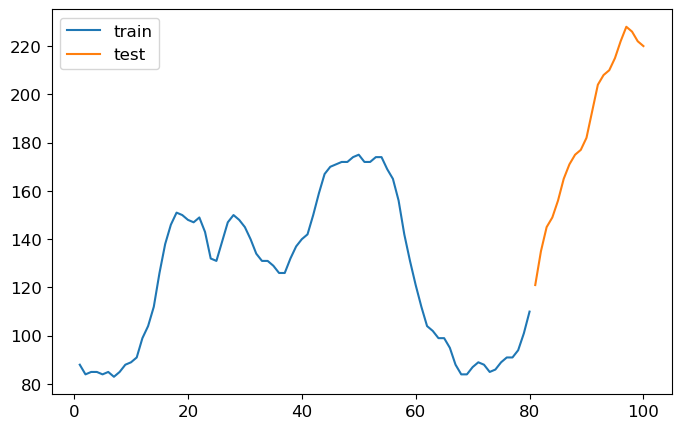

In [5]:
# Separación los datos en train y test.
# Train test split 80% datos de entrenamiento y 20% datos de prueba.
data_train, data_test = split_dataset(data)

fig, ax = plt.subplots(figsize=(8, 5))
data_train['values'].plot(ax=ax, label='train')
data_test['values'].plot(ax=ax, label='test')
ax.legend();


#### Analizar la serie de tiempo

<AxesSubplot:>

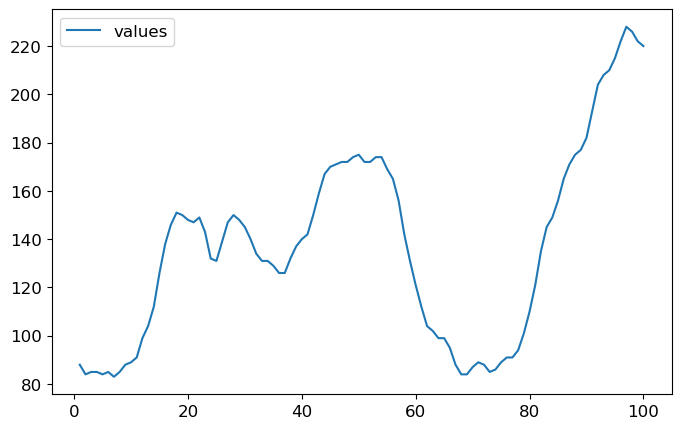

In [6]:
# Mostramos la serie de tiempo
df.plot(figsize=(8,5))

In [7]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
df_ciclo, df_tend = sm.tsa.filters.hpfilter(df['values'])
df['tend'] = df_tend

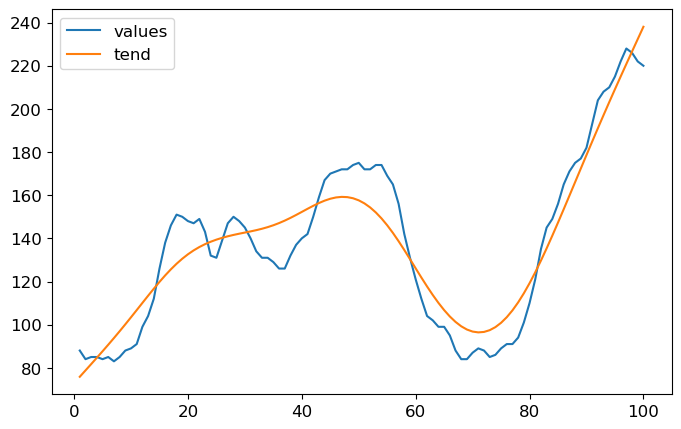

In [8]:
# graficando la serie de tiempo con la tendencia.
df[['values', 'tend']].plot(figsize=(8, 5), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

#### Modelar la serie de tiempo

In [9]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [10]:
adf_test(data_train)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


Conclusiones:
No es estacionaria por que no cumple con que el p-value sea menor que 0.05 por lo tanto vamos a probar con diferenciaciones

In [11]:
# Ilustración de la diferenciación en pandas
ilustracion = pd.DataFrame()

ilustracion['real'] = data_train
ilustracion['1d'] = data_train.diff()
ilustracion['p=2'] = data_train.diff(periods=2)
ilustracion['2d'] = data_train.diff().diff()

ilustracion

,real,1d,p=2,2d
1,88,NaN,NaN,NaN
2,84,-4.0,NaN,NaN
3,85,1.0,-3.0,5.0
4,85,0.0,1.0,-1.0
5,84,-1.0,-1.0,-1.0
...,...,...,...,...
76,91,2.0,5.0,-1.0
77,91,0.0,2.0,-2.0
78,94,3.0,3.0,3.0
79,101,7.0,10.0,4.0


In [12]:
diff1_values = data_train.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = data_train.diff().diff().dropna()
print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


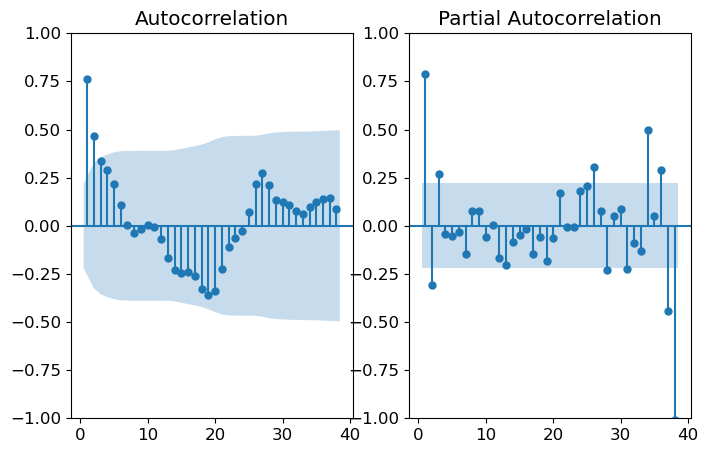

In [13]:
# 1. Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(diff1_values, {'lags':38})

En base a los gráficos anteriores con diferenciación 1, los posibles valores de $p$, $d$ y $q$ son 3,1,2.

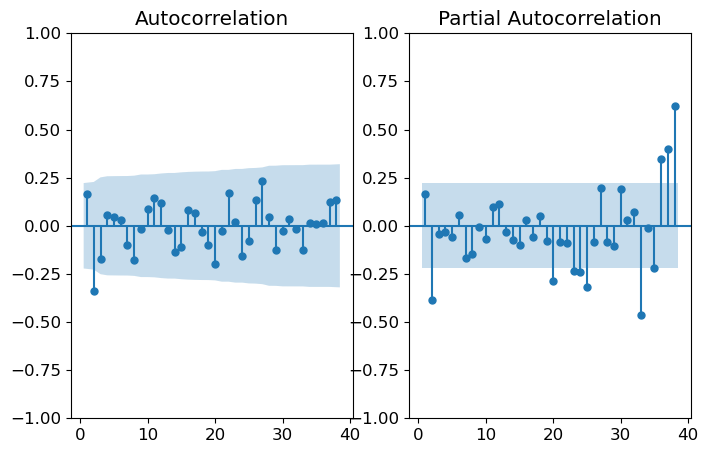

In [14]:
plot_acf_pacf(diff2_values, {'lags':38})

En base a los gráficos anteriores con diferenciación 2, los posibles valores de $p$, $d$ y $q$ son 2,2,2.

#### Modelo 1 ARIMA(3,1,2)

In [15]:
# 1. Modelo de diferencia de primer orden
arima_model1 = ARIMA(data_train, order=(3, 1, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -201.589
Date:                Tue, 07 Feb 2023   AIC                            415.178
Time:                        17:24:51   BIC                            429.394
Sample:                             0   HQIC                           420.873
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1445      0.227     -0.636      0.525      -0.590       0.301
ar.L2          0.1469      0.227      0.648      0.517      -0.297       0.591
ar.L3          0.3064      0.189      1.621      0.1

<AxesSubplot:>

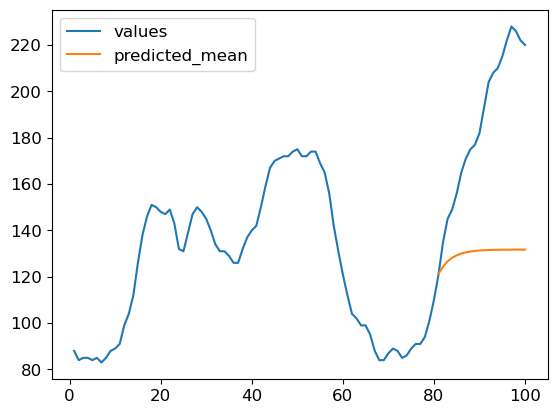

In [16]:
# Predicción
y_h = model1.predict(start=81, end=100, dynamic=False).to_frame()

ax = data.plot()

y_h.plot(ax=ax)

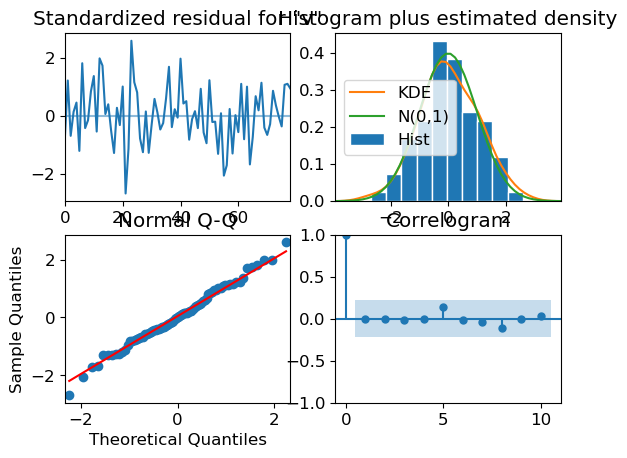

In [17]:
# Gráfico de los diagnósticos para los residuos
model1.plot_diagnostics();

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
mse, rmse, mad, mape = evaluate_forecasts(data_test, y_h)
result1 = pd.DataFrame([mse, rmse, mad, mape]).T
result1.columns = ["mse", "rmse", "mad", "mape"]
result1

,mse,rmse,mad,mape
0,4065.706201,4065.706201,56.227802,0.280692


#### Modelo 2 ARIMA(2,2,2)

In [19]:
arima_model2 = ARIMA(data_train, order=(2, 2, 2))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -202.613
Date:                Tue, 07 Feb 2023   AIC                            415.225
Time:                        17:24:52   BIC                            427.009
Sample:                             0   HQIC                           419.943
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4506      0.289      1.562      0.118      -0.115       1.016
ar.L2         -0.2584      0.262     -0.985      0.325      -0.772       0.256
ma.L1         -0.2520      0.294     -0.857      0.3

<AxesSubplot:>

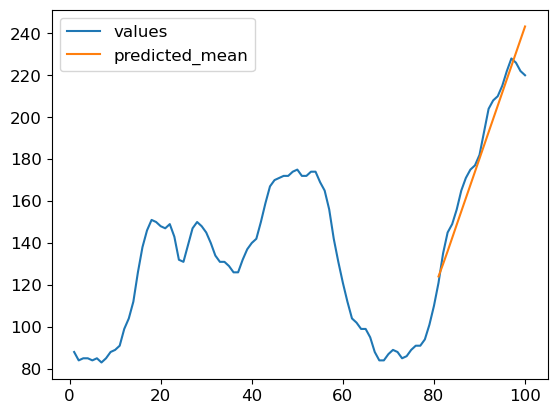

In [20]:
# Cómo realizar predicciones con el modelo ajustado
y_h2 = model2.predict(start=81, end=100, dynamic=False).to_frame()

ax = data.plot()

y_h2.plot(ax=ax)

In [21]:
mse, rmse, mad, mape = evaluate_forecasts(data_test, y_h2)
result2 = pd.DataFrame([mse, rmse, mad, mape]).T
result2.columns = ["mse", "rmse", "mad", "mape"]
result2

,mse,rmse,mad,mape
0,77.954015,77.954015,7.362009,0.039743


#### Modelo 3 ARIMA(0,2,2)

In [22]:
arima_model3 = ARIMA(data_train, order=(1, 2, 2))
model3 = arima_model3.fit()
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -201.756
Date:                Tue, 07 Feb 2023   AIC                            411.512
Time:                        17:24:53   BIC                            420.938
Sample:                             0   HQIC                           415.285
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6478      0.113      5.720      0.000       0.426       0.870
ma.L1         -0.5207      4.108     -0.127      0.899      -8.571       7.530
ma.L2         -0.4789      1.942     -0.247      0.8

<AxesSubplot:>

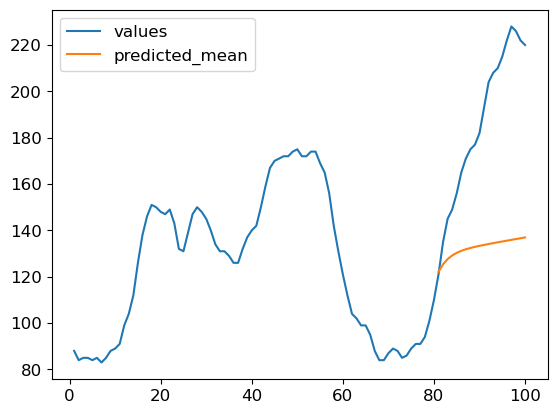

In [23]:
# Cómo realizar predicciones con el modelo ajustado
y_h3 = model3.predict(start=81, end=100, dynamic=False).to_frame()

ax = data.plot()

y_h3.plot(ax=ax)

In [24]:
mse, rmse, mad, mape = evaluate_forecasts(data_test, y_h3)
result3 = pd.DataFrame([mse, rmse, mad, mape]).T
result3.columns = ["mse", "rmse", "mad", "mape"]
result3

,mse,rmse,mad,mape
0,3712.482644,3712.482644,53.809931,0.268807


Conclusiones:

Después de analizar los modelos propuestos para este ejercicio llegue a la conclusión de que el mejor modelo es el 2 con arima de (2,2,2) ya que la log verosimilitud es mas alta que la de los demás modelos y el AIC y BIC son más bajos. En los resultados del mae, mape, mse tambien fue el ganador.

### Parte #2

Ahora vamos a normalizar la serie de tiempo 

In [25]:
#Usamos MinMaxScaler 
from sklearn.preprocessing import MinMaxScaler
# normalizacion de los dato6s
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)
dataset = pd.DataFrame(dataset)
dataset.rename({0: 'values'}, axis=1, inplace=True)
dataset.head()

,values
0,0.034483
1,0.006897
2,0.013793
3,0.013793
4,0.006897


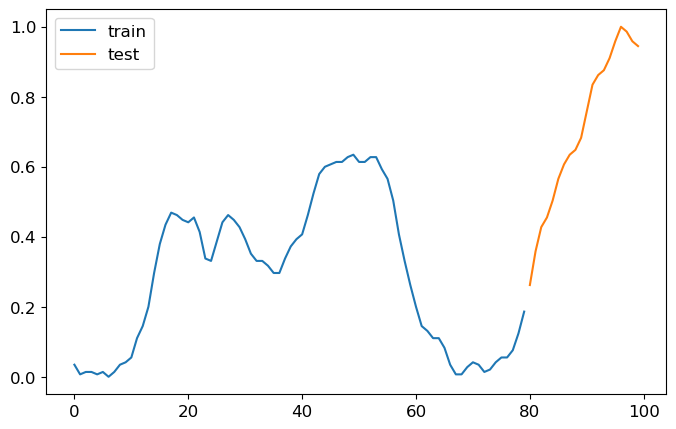

In [26]:
# Train test split 80% datos de entrenamiento y 20% datos de prueba.
dataset_train, dataset_test = split_dataset(dataset)

fig, ax = plt.subplots(figsize=(8, 5))
dataset_train['values'].plot(ax=ax, label='train')
dataset_test['values'].plot(ax=ax, label='test')
ax.legend();

<AxesSubplot:>

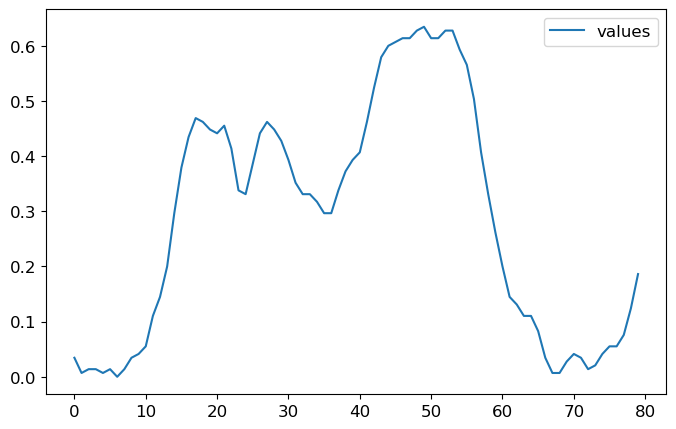

In [27]:
# Mostramos la serie de tiempo normalizada para los datos de entrenamiento
dataset_train.plot(figsize=(8,5))

In [28]:
adf_test(dataset_train)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


In [29]:
# Ilustración del método differencing con pandas
ilustracion3 = pd.DataFrame()

ilustracion3['real'] = dataset_train
ilustracion3['1d'] = dataset_train.diff()
ilustracion3['p=2'] = dataset_train.diff(periods=2)
ilustracion3['2d'] = dataset_train.diff().diff()

ilustracion3

,real,1d,p=2,2d
0,0.034483,NaN,NaN,NaN
1,0.006897,-0.027586,NaN,NaN
2,0.013793,0.006897,-0.020690,0.034483
3,0.013793,0.000000,0.006897,-0.006897
4,0.006897,-0.006897,-0.006897,-0.006897
...,...,...,...,...
75,0.055172,0.013793,0.034483,-0.006897
76,0.055172,0.000000,0.013793,-0.013793
77,0.075862,0.020690,0.020690,0.020690
78,0.124138,0.048276,0.068966,0.027586


In [30]:
diff12_values = dataset_train.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff12_values)

diff22_values = dataset_train.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff22_values)


ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


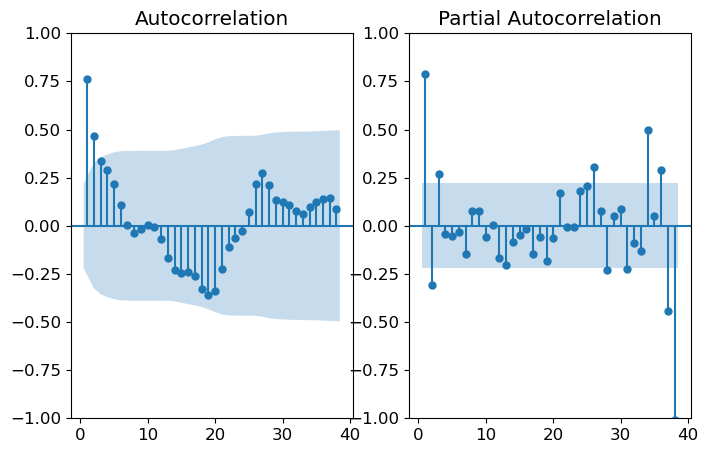

In [31]:
# Graficos del ACF y PACF de primer orden
plot_acf_pacf(diff12_values, {'lags':38})

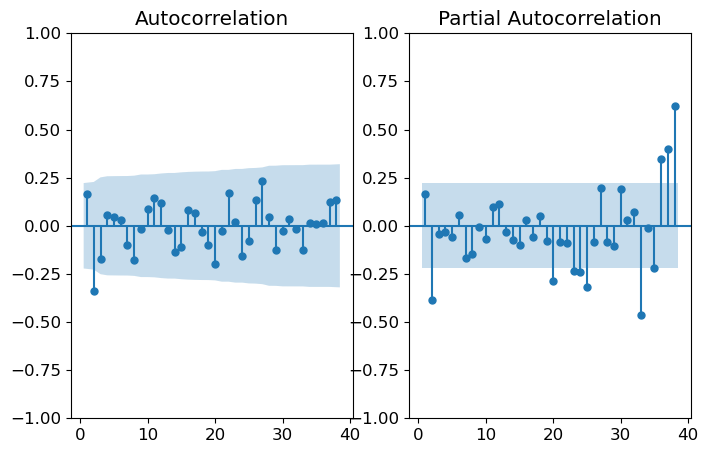

In [32]:
# Graficos del ACF y PACF con segunda diferenciación
plot_acf_pacf(diff22_values, {'lags':38})

In [33]:
# 1. Modelo de diferencia de primer orden
arima_model12 = ARIMA(dataset, order=(3, 1, 4))
model12 = arima_model12.fit()
print(model12.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(3, 1, 4)   Log Likelihood                 243.083
Date:                Tue, 07 Feb 2023   AIC                           -470.165
Time:                        17:24:54   BIC                           -449.404
Sample:                             0   HQIC                          -461.765
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4550      0.235      6.200      0.000       0.995       1.915
ar.L2         -1.1419      0.410     -2.786      0.005      -1.945      -0.339
ar.L3          0.3973      0.249      1.597      0.1

In [34]:
# 2. Modelo de diferencia de segundo orden

# Basado en lo discutido anteriormente, necesitamos sólo considerar algunos términos AR y MA.
# Para ello definimos sus coeficientos cómo la especificación de polinomios

# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model22 = ARIMA(dataset, order=(ar, 2, ma))
model22 = arima_model22.fit()
print(model22.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:             ARIMA([2], 2, [2])   Log Likelihood                 230.889
Date:                Tue, 07 Feb 2023   AIC                           -455.779
Time:                        17:24:54   BIC                           -448.024
Sample:                             0   HQIC                          -452.642
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.4587      0.218     -2.102      0.036      -0.886      -0.031
ma.L2          0.0670      0.254      0.264      0.792      -0.432       0.566
sigma2         0.0005   8.64e-05      6.131      0.0

<AxesSubplot:>

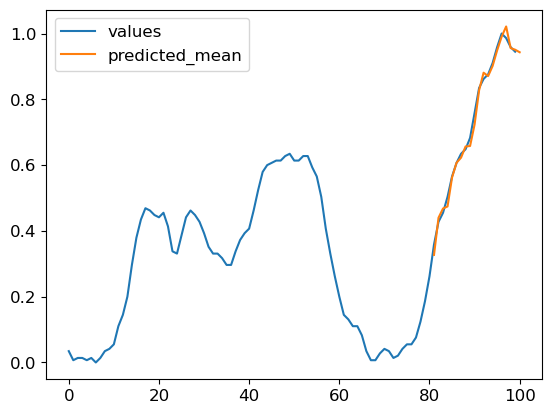

In [35]:
# Cómo realizar predicciones con el modelo ajustado
y_h4 = model12.predict(start=81, end=100, dynamic=False).to_frame()

ax = dataset.plot()

y_h4.plot(ax=ax)

<AxesSubplot:>

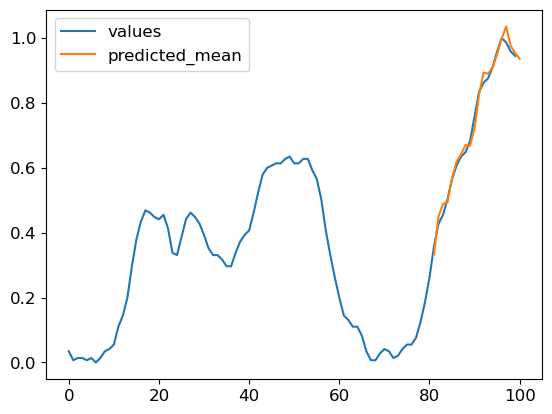

In [36]:
# Cómo realizar predicciones con el modelo ajustado
y_h5 = model22.predict(start=81, end=100, dynamic=False).to_frame()

ax = dataset.plot()

y_h5.plot(ax=ax)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
mse, rmse, mad, mape = evaluate_forecasts(dataset_test, y_h4)
result4 = pd.DataFrame([mse, rmse, mad, mape]).T
result4.columns = ["mse", "rmse", "mad", "mape"]
result4

,mse,rmse,mad,mape
0,0.001607,0.001607,0.033821,0.063086


In [38]:
mse, rmse, mad, mape = evaluate_forecasts(dataset_test, y_h5)
result5 = pd.DataFrame([mse, rmse, mad, mape]).T
result5.columns = ["mse", "rmse", "mad", "mape"]
result5

,mse,rmse,mad,mape
0,0.002241,0.002241,0.041936,0.077884


Conclusión:

Para la segunda parte de la tarea el mejor modelo fue el primero por que obtuvo un log likelihood mayor que el segundo,aparte en las metricas de evaluación obtuvo menor error el primer modelo.

### Parte#3

In [39]:
import requests
from datetime import datetime
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
data2.head()

,air,time,t
1949-01-01,112,1949.000000,1.0
1949-02-01,118,1949.083374,2.0
1949-03-01,132,1949.166626,3.0
1949-04-01,129,1949.250000,4.0
1949-05-01,121,1949.333374,5.0


como solo vamos a analizar el aire vamos a eliminar las columnas que no utilizaremos

In [40]:
data2 = data2.drop(columns=["time", "t"])
data2.tail()

,air
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


<AxesSubplot:>

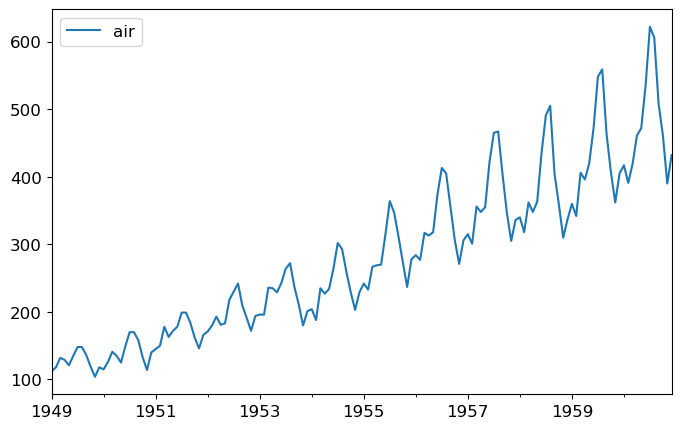

In [41]:
#Ahora vamos a graficar la serie de tiempo
# Mostramos la serie de tiempo
data2.plot(figsize=(8,5))

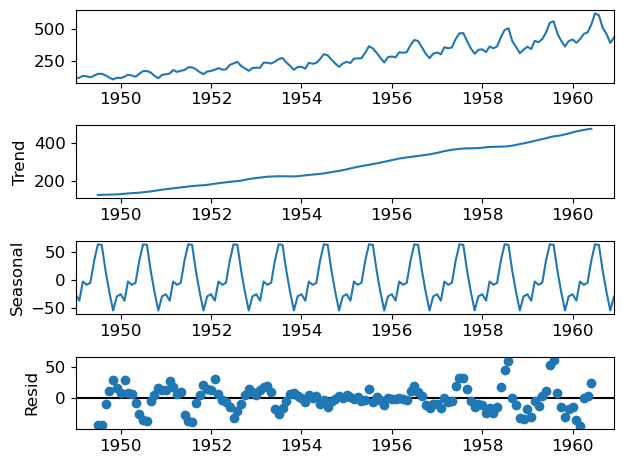

In [42]:
# Descomposición estacional de la serie de tiempo
decompose2 = seasonal_decompose(data2, model="additive", period=12)
decompose2.plot();

Conclusiones:

Esta grafica nos muestra que la serie de tiempo tiene estacionalidad

<AxesSubplot:>

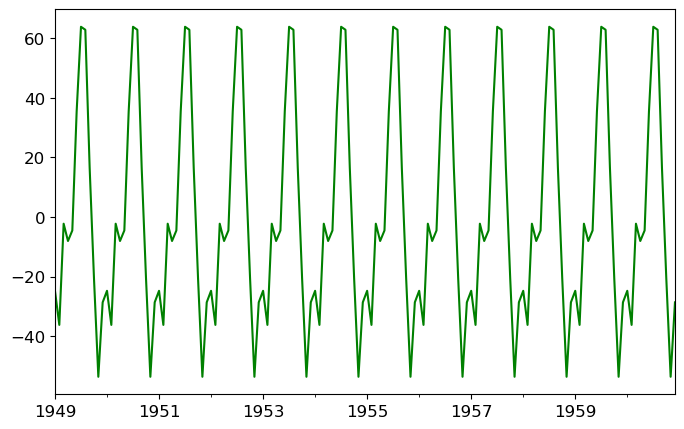

In [43]:
# solo nos quedamos con la parte estacional 
seasonality= decompose2.seasonal
seasonality.plot(color='green', figsize=(8,5))

In [44]:
# Evaluamos si tiene estacionariedad
adf_test(data2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Non-stationary


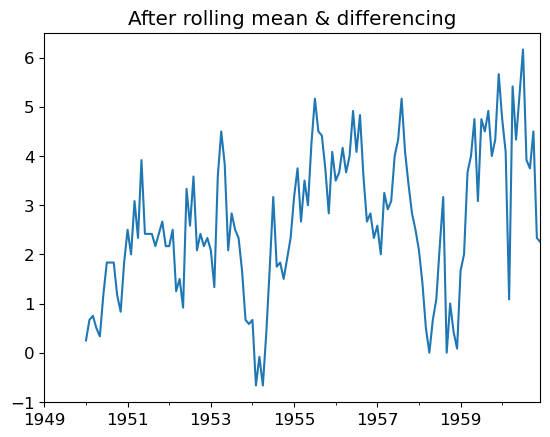

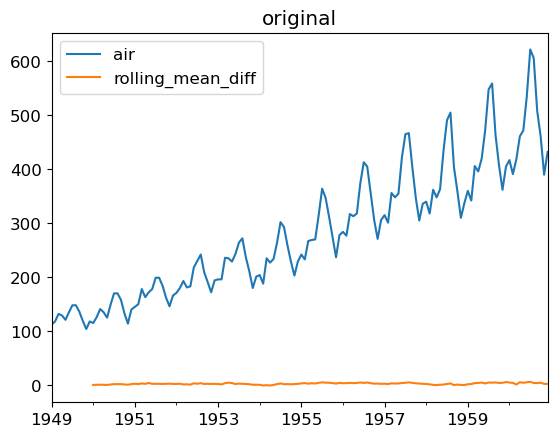

In [45]:
# Diferenciación
rolling_mean = data2.rolling(window = 12).mean()
data2['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data2['rolling_mean_diff'].plot(title='After rolling mean & differencing');
ax2 = plt.subplot()
data2.plot(title='original');

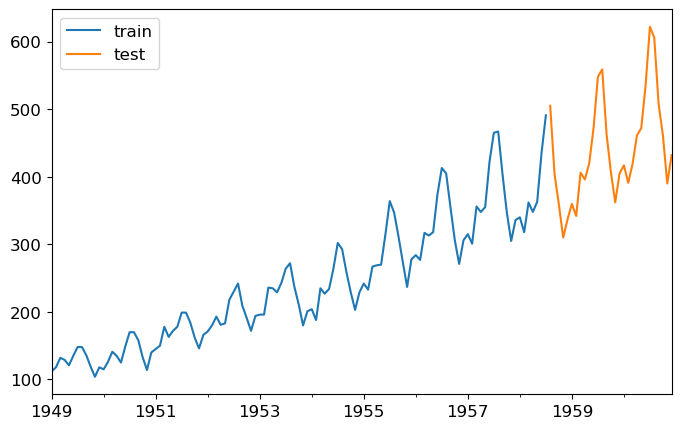

In [46]:
# Separación los datos en train y test.
data2_train, data2_test = split_dataset(data2)

fig, ax = plt.subplots(figsize=(8, 5))
data2_train['air'].plot(ax=ax, label='train')
data2_test['air'].plot(ax=ax, label='test')
ax.legend();

In [47]:
adf_test(data2["rolling_mean_diff"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Stationary


In [48]:
# Modelo 1
arima_model123 = ARIMA(data2_train["air"], order=(3, 1, 4))
model123 = arima_model123.fit()
print(model123.summary())

                               SARIMAX Results                                
Dep. Variable:                    air   No. Observations:                  115
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -511.860
Date:                Tue, 07 Feb 2023   AIC                           1039.720
Time:                        17:24:57   BIC                           1061.610
Sample:                    01-01-1949   HQIC                          1048.604
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8643      0.175      4.934      0.000       0.521       1.208
ar.L2         -0.7515      0.180     -4.169      0.000      -1.105      -0.398
ar.L3          0.0068      0.169      0.041      0.9

<AxesSubplot:>

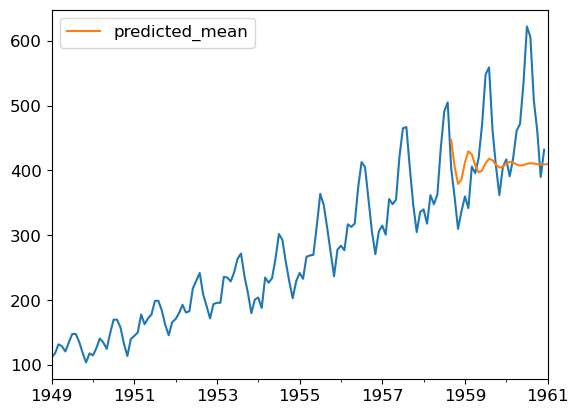

In [49]:
# Predicción
y_h23 = model123.predict(start= 116, end=144, dynamic=False).to_frame()

ax = data2['air'].plot()

y_h23.plot(ax=ax)

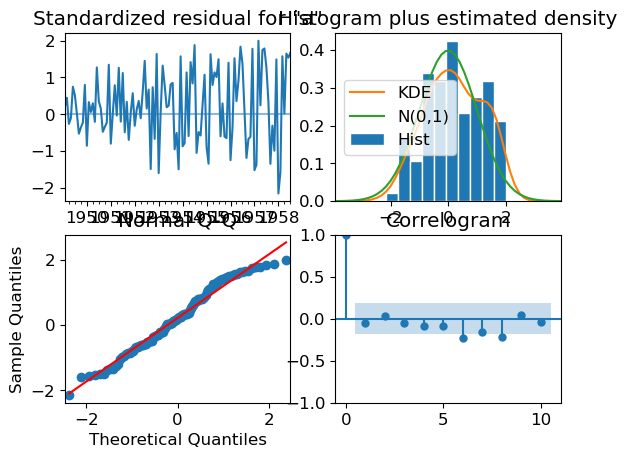

In [50]:
# Gráfico de los diagnósticos para los residuos
model123.plot_diagnostics();

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
mse, rmse, mad, mape = evaluate_forecasts(data2_test["air"], y_h23)
result = pd.DataFrame([mse, rmse, mad, mape]).T
result.columns = ["mse", "rmse", "mad", "mape"]
result

,mse,rmse,mad,mape
0,6627.84657,6627.84657,59.362461,0.126026


In [52]:
sarimax = sm.tsa.statespace.SARIMAX(data2_train['air'], order=(1, 1, 1), seasonal_order=(1,1,1,20))
r = sarimax.fit()

<AxesSubplot:>

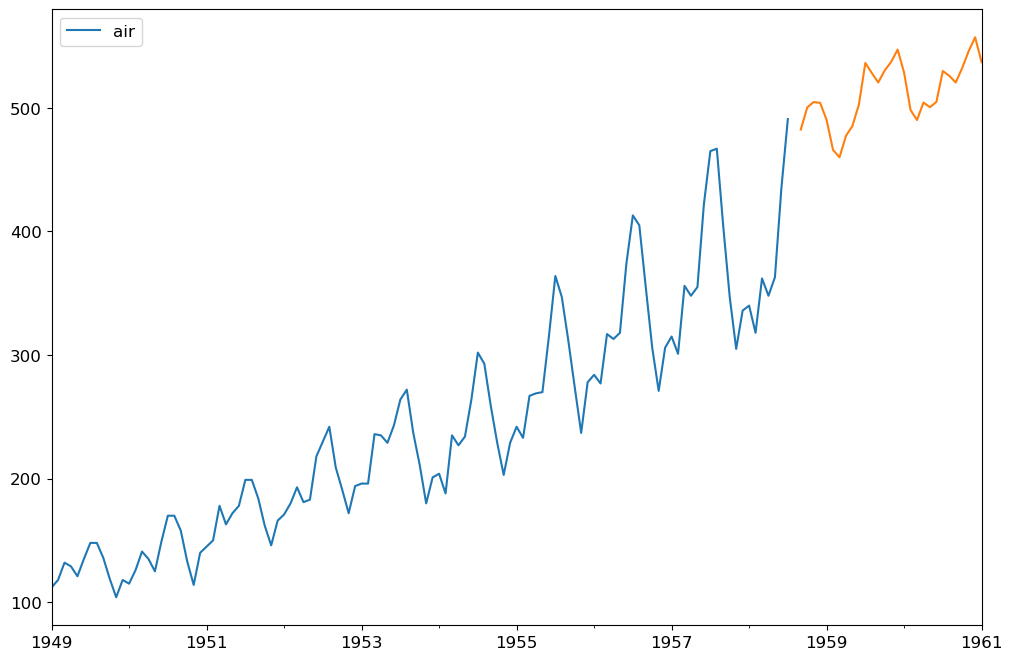

In [54]:
forecast = r.predict(start=116,end=144)
data2_train[['air']].plot(figsize=(12,8))
forecast.plot()

In [55]:
mse, rmse, mad, mape = evaluate_forecasts(data2_test['air'], forecast)
results6 = pd.DataFrame([mse, rmse, mad, mape]).T
results6.columns = ["mse", "rmse", "mad", "mape"]
results6

,mse,rmse,mad,mape
0,10484.325297,10484.325297,90.163541,0.225793


### Parte 4

In [56]:
arima_model1234 = ARIMA(data2_train["air"], order=(0,1,2))
model1234 = arima_model1234.fit()
print(model1234.summary())

                               SARIMAX Results                                
Dep. Variable:                    air   No. Observations:                  115
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -527.343
Date:                Tue, 07 Feb 2023   AIC                           1060.685
Time:                        17:25:19   BIC                           1068.894
Sample:                    01-01-1949   HQIC                          1064.017
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4087      0.085      4.819      0.000       0.243       0.575
ma.L2         -0.2785      0.077     -3.640      0.000      -0.428      -0.129
sigma2       607.2547    109.283      5.557      0.0

<AxesSubplot:>

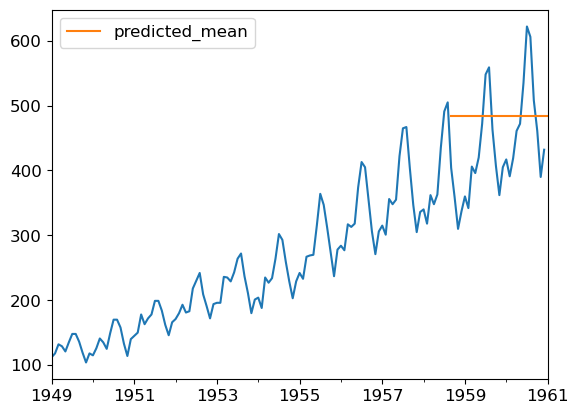

In [57]:
y_h234 = model1234.predict(start= 116, end=144, dynamic=False).to_frame()

ax = data2['air'].plot()

y_h234.plot(ax=ax)

In [58]:
# Predicción
from pandas.tseries.offsets import DateOffset
pred_date=[data2.index[-1]+ DateOffset(months=x)for x in range(0,12)]

In [59]:
pred_date = pd.DataFrame(index=pred_date[1:],columns=data2.columns)
pred_date.head()

,air,rolling_mean_diff
1961-01-01,NaN,NaN
1961-02-01,NaN,NaN
1961-03-01,NaN,NaN
1961-04-01,NaN,NaN
1961-05-01,NaN,NaN


In [60]:
data3=pd.concat([data2,pred_date])
data3.head()

,air,rolling_mean_diff
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN


<AxesSubplot:>

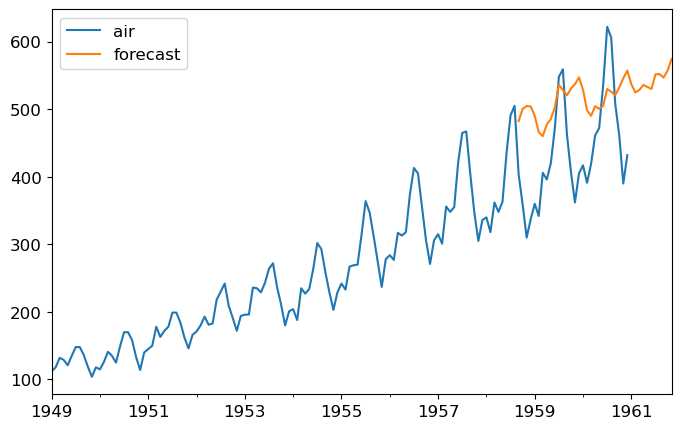

In [61]:
# Predicción a 20 unidades en el futuro
data3['forecast'] = r.predict(start=116,end=164, dynamic= True)
data3[['air', 'forecast']].plot(figsize=(8, 5))

Conclusión:

Para concluir el modelo SARIMA no fue tan bueno como los otros que probamos en la tarea, apesar que utilizamos 20 unidades para el futuro.

### <span style="color:darkblue"> Alumno #2: Leonardo Xavier Pérez Balcorta </span>

In [2]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# plt.rc("figure", figsize=(11,8))
plt.rc("font", size=12)

data = pd.read_csv('../MPST-2023-I/TEMA-1/datasets/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()

C:\Users\PerezBL\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
##Función para ver si pasa la prueba de hipotesis

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        

##Función para graficar ACF y PACF

def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()
    
#Función para dividir la información de prueba y aplicación 
def split_dataset(dataSet,testPercent):
    """
    Función que se encarga de dividir la data ingresada en datos de entrenamiento y prueba.
    :param data: Data con la información de la serie de tiempo a analizar.
    """
    paramData = {}

    valorDivisor = round(len(dataSet)*testPercent) #Este valor se encarga de dividir el 70 y 30% de los datos

    paramData['datosEntrenamiento'] = dataSet.iloc[:valorDivisor]

    paramData['datosPrueba'] = dataSet.iloc[valorDivisor:]

    return paramData

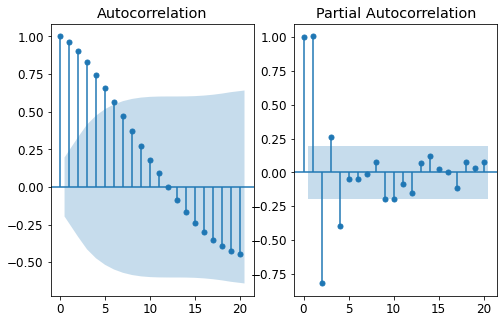

In [4]:
# Escoger parámetros de ARIMA

# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(data, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(data, ax=ax2, method='ols')

plt.show()

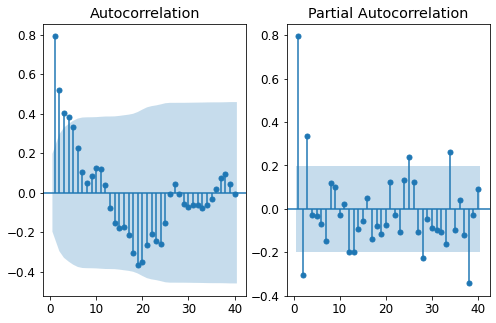

In [5]:
diff_values = data.diff().dropna()
# 1. Graficar ACF y PACF

plot_acf_pacf(diff_values, {'lags':40})

Se puede observar que tiene una parte MA de 4, sin embargo para esta tarea jugaré con esa temporalidad, ya que tambien el dia 5 esta muy cerca, la única diferencia es que esta dentro del área azul.

Por la parte AR utilizaremos los 3 valores importantes para predecir.

In [6]:
# 1. Modelo de diferencia de primer orden
# Este modelos tiene los AIC y los BIC mas bajos, sin emabrgo el likelihood tiene una variación de .15, sin embargo, le doy mas importancia a los errores que al likelihood.
arima_model = ARIMA(data, order=(3, 1, 3))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -249.036
Date:                Tue, 07 Feb 2023   AIC                            512.071
Time:                        17:51:48   BIC                            530.237
Sample:                             0   HQIC                           519.421
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6807      0.094     17.841      0.000       1.496       1.865
ar.L2         -1.6067      0.118    -13.648      0.000      -1.837      -1.376
ar.L3          0.6775      0.098      6.915      0.0

Aquí se utiliza el MinMaxScaler para poder normalizar los datos.

In [7]:
scaler = MinMaxScaler()
scaler.fit(data)
values = scaler.transform(data)

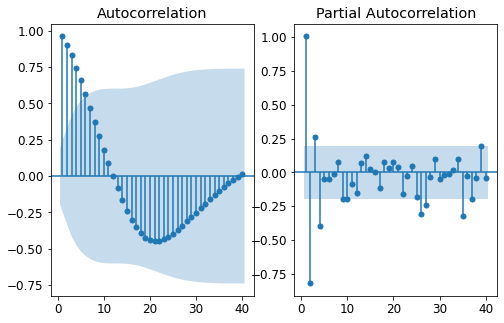

In [9]:
# Graficar ACF y PACF

plot_acf_pacf(values, {'lags':40})

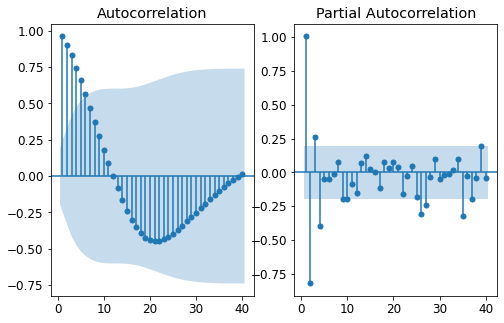

In [10]:
diff_values = pd.DataFrame(values).dropna()

plot_acf_pacf(diff_values, {'lags':40})

En ambos casos presenta que no tiene MA, por lo tanto es 0 en ambos casos y la parte autoregresiva es 3 y que el primer valor es igual a 1 y ese no cuenta

In [11]:
# 1. Modelo de diferencia de primer orden
arima_model = ARIMA(data, order=(3,1,0))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -251.997
Date:                Tue, 07 Feb 2023   AIC                            511.995
Time:                        17:52:41   BIC                            522.375
Sample:                             0   HQIC                           516.195
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1513      0.103     11.214      0.000       0.950       1.353
ar.L2         -0.6612      0.134     -4.932      0.000      -0.924      -0.398
ar.L3          0.3407      0.094      3.641      0.0

Comparando con los datos pasados, podemos ver que los errores (AIC y BIC) disminuyen, sin embargo el likelihood aumento.

### Sarimax

Es un modelo que parte del Arima, también cuenta con una parte autoregresiva, medias moviles y estacionales. por eso la S en su nombre (Seasonal) 

In [12]:
model=sm.tsa.statespace.SARIMAX(data,order=(3, 1, 3),seasonal_order=(3,1,3,12))

results=model.fit()


<AxesSubplot:>

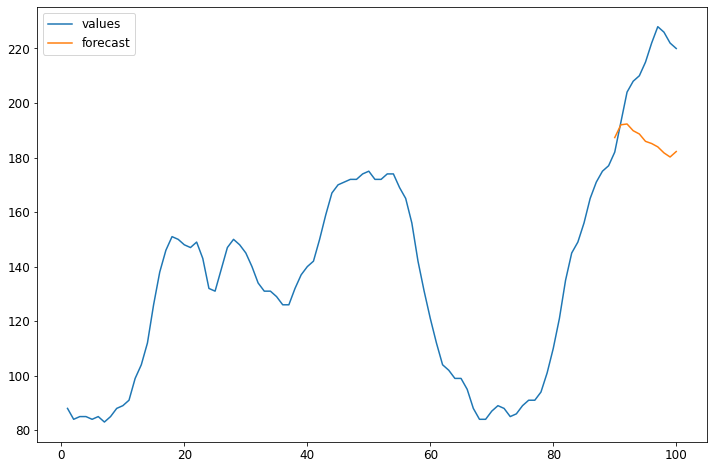

In [13]:
data['forecast']=results.predict(start=90,end=103,dynamic=True)
data[['values','forecast']].plot(figsize=(12,8))